#  Project 3: Simulating Human Population Growth and Migration

**by Kartikeya Kumar and Karan Shah**

In [1]:
import numpy as np
import matplotlib.pyplot as plt # Core plotting support
import math
%matplotlib inline

np.random.seed(1611044230)

def show_grid (grid):
    plt.matshow (grid)

In [2]:
#Global Variables
num_countries = 8 #No of countries on the map
M = 30 #Grid size M x N
N = 30
POP_LIMIT = 100 #Max number of people in each cell
WEIGHTW = 0.75 #Weight of wealth difference
WEIGHTP = 0.25 #Weight of population
attributes = ["Country No " , "Population Density", "Wealth Score", "Elevation", "Birth Rate1","Birth Rate2" ,"Death Rate1", "Death Rate2",  "Population Counter", "Temperature"]


In [3]:
# It takes in mean and size and returns a Gaussian distribution as proposed in conceptual model. 
# Check distributionGen.ipnyb for plots.

def create_distribution(size, p):
    assert(p>=0.0 and p<=1.0),"Straight outta bounds"
    sigma = 1
    mu = 0
    s = size

    x = np.linspace(0,1,s)
    y=1/( np.sqrt(2 * np.pi) *np.exp((-6*p+6*x)**2 / 2))
    y=y/0.4

    maxind = np.searchsorted(y,1.0)
    minind = np.searchsorted(y,0.0)

    y=y[minind:maxind]
    np.random.shuffle(y)

    return y

In [4]:
#Initialize the World Grid and assign numbers to countries. Need to make this dynamic
def initialize_world(m, n, num_attributes, num_countries):
    world = np.empty([m, n, num_attributes+2], dtype = float)
    no = num_countries/2
    for k in range(1, num_countries+1):
        if k <= no:
            naxis = 0
            maxis = k
        else:
            naxis = 1
            maxis = k-no
            
        world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,0]=k
    
    for i in range(M):
        for j in range(N):
            world[i,j,-2] = i
            world[i,j,-1] = j
    return world


In [5]:
#Initialize the Dictionary representing each country and their attribute values
#print(len(attributes))
#print(np.zeros( len(attributes)))
def initialize_country_properties(num_countries):
    country_properties = {}
    for i in range(1, num_countries + 1):
        value = np.zeros(len(attributes))
        value[0] = i
        value[1] = np.random.uniform(0.3, 0.8)      #Popdensity
        value[2] = np.random.uniform()              #Wealth
        value[3] = np.random.uniform()              #Elevation
        value[4] = np.random.uniform(0.0,0.07)       #Birth Rate1 
        value[5] = np.random.uniform(0.0,0.0001)     #Birth Rate2
        value[6] = np.random.uniform(0.0,0.02)      #Death Rate1 
        value[7] = np.random.uniform(0.0,0.0004)     #Death Rate2
        country_properties[i] = value
    #print(country_properties)
    return country_properties

In [6]:
def distribute_values(M, N, dataArray):
    
    no = num_countries/2
    tempdiff = 30.0/M
    naxis = 0
    maxis = 0
    
    #print(dataArray)
    for k in dataArray:
        if k <= no:
            naxis = 0
            maxis = k
        else:
            naxis = 1
            maxis = k-no
                
        for i in range(1,4):
            #dist = create_distribution(world[:,:,i].size,dataArray[k][i] )
            
            dist = create_distribution(world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,i].size, dataArray[k][i])
            dist = np.reshape(dist, world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,i].shape)
            
            if(i == 1):
                world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,i] = dist*POP_LIMIT
                totalpop = np.sum(dist)*POP_LIMIT
                dataArray[k][len(attributes) - 2] = totalpop
                world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,len(attributes) - 2] = totalpop
                
            else:
                world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,i] = dist
       
        #world[(maxis-1)*M/no:maxis*M/no, ((naxis)/2)*N: ((naxis+1)/2)*N,len(attributes)-1] =
        #POP_LIMIT* world[(maxis-1)*M/no:maxis*M/no, ((naxis)/2)*N: ((naxis+1)/2)*N,1]
        #totalpop = np.sum(world[(maxis-1)*M/no:maxis*M/no, ((naxis)/2)*N: ((naxis+1)/2)*N,len(attributes)-1])
        #dataArray[k][len(attributes) - 1] = totalpop
        
        for i in range(4,8):
            world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,i] = dataArray[k][i]
            
    for i in range(M): #3D: Added temperature
        world[i,:,9] = 30-i*tempdiff
        
    #print(dataArray)

In [7]:
#Population change logistic equation
def pop_change(dataArray):
    no = num_countries/2
    naxis = 0
    maxis = 0
    w2 = np.square(world[:,:,1])
    
    for k in dataArray:
        if k <= no:
            naxis = 0
            maxis = k
        else:
            naxis = 1
            maxis = k-no
        
        a = dataArray[k][4]-dataArray[k][6]
        b = dataArray[k][5]+dataArray[k][7]
        p = world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,1]
        p2 = np.square(p)
        delp = p*a-p2*b
        delp2 = -dataArray[k][6]*p - dataArray[k][7]*p2
        
        temp = world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,1]
        #print(temp.shape)
        btemp = ((temp+delp) < POP_LIMIT)
        #print(btemp.shape)
        #print(delp.shape)
        temp[btemp] += delp[btemp]
        #print(temp.shape)
        temp[np.invert(btemp)] += delp2[np.invert(btemp)]
        #print(temp.shape)
        
        world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,1] = temp
        totalpop = np.sum(world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,1])
        #print(world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,1]>POP_LIMIT
        dataArray[k][len(attributes) - 2] = totalpop
        
    
    

In [8]:
#Find best countries for each cell to move to
def findIntMatrix(dataArray, w1 = WEIGHTW, w2 = WEIGHTP):
    destMatrix = np.zeros((M,N))
    scoreMatrix = np.zeros((M,N,num_countries))
    no = num_countries/2
    naxis = 0
    maxis = 0
    
    for k in dataArray:
        if k <= no:
            naxis = 0
            maxis = k
        else:
            naxis = 1
            maxis = k-no
        
        for l in dataArray:
            if(l==k):
                scoreMatrix[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,l-1] = -2
            else:
                cw = np.ones(world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,1].shape)*dataArray[l][2]
                cp = np.ones(world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,1].shape)*(np.abs(dataArray[l][1]-0.5))
                w = w1*(cw - world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,1])
                p = w2*cp
       
                scoreMatrix[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,l-1] = w+p
        
        destMatrix = np.argmax(scoreMatrix, axis = 2) + 1
        #print(destMatrix)
               
    return destMatrix
#findIntMatrix(country_properties)

In [9]:
#Return the best country and the desirability to move to over there
def return_international_matrix():
    matrix = findIntMatrix(country_properties)
    result = desirable_location_country()
    answer = np.zeros(matrix.shape, dtype = object)
    for i in range(0, len(answer)):
        for j in range(0, len(answer[0])):
            answer[i][j] = (matrix[i][j], result[matrix[i][j]])
    print(answer)
    return answer
#return_international_matrix()

In [10]:
#Return the index of the most desirable location in each country by wealth 
def desirable_location_country():
    result = {}
    naxis = 0
    maxis = 0
    no = num_countries/2
    
    for k in range(1, num_countries+1):
        
        if k <= no:
            naxis = 0
            maxis = k
        else:
            naxis = 1
            maxis = k-no
        wealth = world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N, 2]
        a = world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N]
        flat = wealth.flatten()
        c_1 = flat.argsort()[-1:]
        x_idx, y_idx = np.unravel_index(c_1, wealth.shape)
        i = a[x_idx,y_idx,-2]
        j = a[x_idx,y_idx,-1]
        #print(i.astype(int)[0])
        result[k] = (i.astype(int)[0], j.astype(int)[0])       
    print(result)
    return result
#desirable_location_country()

### find_local_dest

In [11]:
#Recursive definition to find the local destination in the country
def find_local_dest(country, w, p, i ,j,ww,wp):
    if (country.shape == (1,1,len(attributes)+2)):
        d = desirability(w,country[0,0,2],p,country[0,0,1],i,country[0,0,-2],j,country[0,0,-1],ww,wp)
        #print (country)
        return np.array([country[0,0,-1],country[0,0,-1],d])
    countries = []
    shape = country.shape
    if (shape[0] == 1):
        countries.append(country[0:1, 0: shape[1] // 2])
        countries.append(country[0:1, (shape[1] // 2): shape[1]])
    if (shape[1] == 1):
        countries.append(country[0: shape[0] // 2, 0: 1])
        countries.append(country[shape[0] // 2: shape[0], 0:1])
    if(shape[0] > 1):
        x = shape[0] // 2
    if(shape[1] > 1):
        y = shape[1] // 2
    #N=N+1
    if (shape[0] is not 1 and shape[1] is not 1):
        countries.append(country[0: x,0: y]) #Top Left
        countries.append(country[x :shape[0],0:y])#Bottom Left
        countries.append(country[0: x,y: shape[1]]) #Top Right
        countries.append(country[x : shape[0], y:shape[1]]) # Bottom Right  
    
    wealth = np.zeros(len(countries))
    population = np.zeros(len(countries))
    coordi = np.zeros(len(countries))
    coordj = np.zeros(len(countries))
    
    for k in range(len(countries)):
        wealth[k] = np.sum(countries[k][:,:,2]) / (np.shape(countries[k])[0] * np.shape(countries[k])[1])
    
    for k in range(len(countries)):
        population[k] = np.sum(countries[k][:,:,1]) / (np.shape(countries[k])[0] * np.shape(countries[k])[1]) 
    
    for k in range(len(countries)):
        if(countries[k].shape[0]==1):
            coordi[k] = countries[k][0,0,-2]
        else: coordi[k] = (countries[k][0,0,-2]+countries[k][-1,0,-2])/2
    
    for k in range(len(countries)):
        if(countries[k].shape[1]==1):
            coordj[k] = countries[k][0,0,-1]
        else: coordj[k] = (countries[k][0,0,-1]+countries[k][0,-1,-1])/2
    
    x = np.zeros(len(countries))
    for k in range(len(countries)):
        x[k] = desirability(w,wealth[k], p, population[k], i, coordi[k],j,  coordj[k], ww,wp) #Pass the correct arguments for location
    #print(x)
    #print(np.argmax(x))
    return find_local_dest(countries[np.argmax(x)], w, p, i, j, ww, wp)

In [12]:
def desirability(w1,w2,p1,p2,i1,i2,j1,j2, weightw, weightp):   #(W_source, W_dest, pop_source, pop_dest, x_source, x_dest, y...)
    distance = math.sqrt((j1 - j2)**2+(i1 - i2)**2)
    if distance == 0:
        return -999
    w = w2 - w1
    p = (0.5 - math.fabs(0.5 - p1/POP_LIMIT)) * 2
    des = ((w)*weightw + p*weightp)/distance
    #print (distance)
    #print(w)
    #print(p)
    #print("END")
    return des

makeLocalDestMatrix(): Makes a matrix with the location and desirability of the most desirable destination cell.

In [13]:
def makeLocalDestMatrix(): #Return a matrix containing most desirable destination for each cell in format 
    #[i,j,delta]
    dest = np.zeros((M,N,3))
    #print("dest")
    #print(dest.shape)
    naxis = 0
    maxis = 0
    no = num_countries/2
    
    for i in range(M):
        for j in range(N):
            k = world[i,j,0]
            if k <= no:
                naxis = 0
                maxis = k
            else:
                naxis = 1
                maxis = k-no
            #Add country finder-done
            country = world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N]
            #print("country")
            #print(k)
            #print("cend")
            a =  find_local_dest(country, world[i,j,1], world[i,j,2], world[i,j,-2],world[i,j,-1],WEIGHTW,WEIGHTP)
            dest[i,j,0] = a[0]
            dest[i,j,1] = a[1]
            dest[i,j,2] = a[2]
    return dest
    

migration(): Initiates all migration functions

In [14]:
def migration(dataArray,rho1,rho2):
    world_temp = np.copy(world)
    no = num_countries/2
    naxis = 0
    maxis = 0
    localdest = makeLocalDestMatrix()
    #intdest = makeInternationalDestMatrix()
    
    for i in range(M):
        for j in range(N):
            
            
            n = world_temp[i,j,1]*rho1*localdest[i,j,2]
            #m = world_temp[i,j,1]*rho2*intdest[i,j,2]
            #print(n)
            if(world[localdest[i][j][0],localdest[i][j][1],1]+n < POP_LIMIT and world[localdest[i][j][0],localdest[i][j][1],1]+n>0):
                if(world[i,j,1]-n < POP_LIMIT and world[localdest[i][j][0],localdest[i][j][1],1]-n>0):
                    world[localdest[i][j][0],localdest[i][j][1],1] += n
                    world[i,j,1]-= n
                
            #if(world[intdest[i][j][0],intdest[i][j][1],1]+m < POP_LIMIT):
               # world[intdest[i][j][0],intdest[i][j][1],1] += m
               # world[i,j,1]-= m
    
    for k in dataArray:
        if k <= no:
            naxis = 0
            maxis = k
        else:
            naxis = 1
            maxis = k-no
        totalpop = np.sum(world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,1])
        #print(world[(maxis-1)*M/no : maxis*M/no, ((naxis)/2)*N : ((naxis+1)/2)*N,1]>POP_LIMIT
        dataArray[k][len(attributes) - 2] = totalpop
    

In [15]:
def engine(country_properties,rho1,rho2):
    pop_change(country_properties)
    migration(country_properties, rho1, rho2)
    #update_pop()

In [16]:
#Make world
world = initialize_world(M, N, len(attributes), num_countries)
country_properties = initialize_country_properties(num_countries)
distribute_values(M,N,country_properties)
m = findIntMatrix(country_properties, 0.75,  0.25) 
#print("Destination matrix:")
#print(m)
a = find_local_dest(world,0.5,0.8,1,1,WEIGHTW,WEIGHTP)
#print(a.shape)
#print(a[0],a[1],a[2])
#print(a)
##print(a[0])
#print(a[1])
#print(a[2])


-c:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:22: DeprecationWarning: using a non-integer number instead of an integer will result 

In [17]:
#def update_pop():
    

In [18]:
#Plot the World Grid
def plot_world():
    for k in country_properties:
        print("Country "+str(k)+" : "+str(np.floor(country_properties[k][len(attributes) - 2])))
    print("The plots represent different attributes of the world grid. The first plot is shows the different countries. The other plots show different attributes on a cellular level.")
#"Country No " , "Population Density", "Wealth Score", "Elevation", "Birth Rate1","Birth Rate2" ,"Death Rate1", "Death Rate2",  "Population Counter", "Temperature"
    #show_grid(world[:,:,0])
    show_grid(world[:,:,1])
    #show_grid(world[:,:,2])
    #show_grid(world[:,:,3])
    #show_grid(world[:,:,4])
    #show_grid(world[:,:,5])
    #show_grid(world[:,:,6])
    #show_grid(world[:,:,7])
    #show_grid(world[:,:,8])
    #show_grid(world[:,:,9])
    #engine(country_properties,0.1,0.1)
    for k in country_properties:
        print("Country "+str(k)+" : "+str(np.floor(country_properties[k][len(attributes) - 2])))
    

#Comment to hide
#plot_world()

Initial population
Country 1 : 4247.0
Country 2 : 4897.0
Country 3 : 4322.0
Country 4 : 4568.0
Country 5 : 4291.0
Country 6 : 4942.0
Country 7 : 4225.0
Country 8 : 4941.0


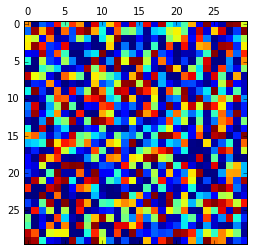

-c:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


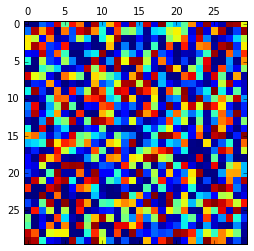

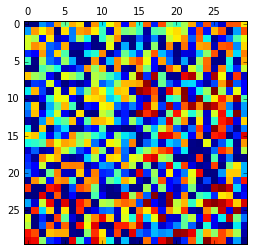

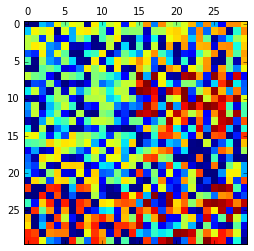

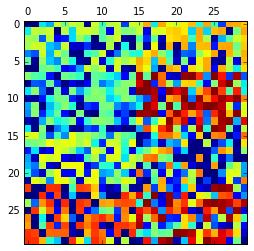

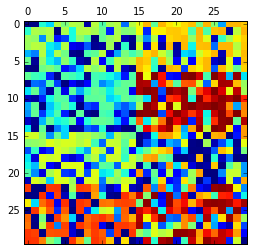

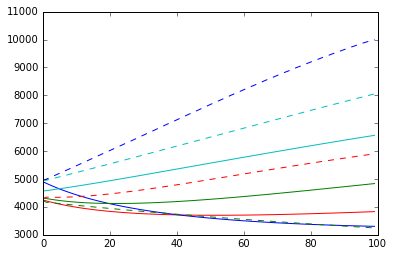

Final population
Country 1 : 3835.0
Country 2 : 3301.0
Country 3 : 4849.0
Country 4 : 6585.0
Country 5 : 5919.0
Country 6 : 10040.0
Country 7 : 3240.0
Country 8 : 8081.0


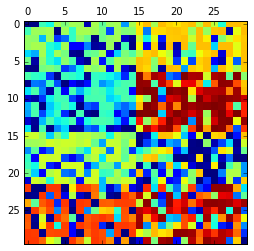

In [19]:
#Shows how population changes with time.
def showPopChange():
    print("Initial population")
    for k in country_properties:
        print("Country "+str(k)+" : "+str(np.floor(country_properties[k][len(attributes) - 2])))

    show_grid(world[:,:,1])
    plt.show()
    t=100
    x = np.zeros(t)
    y = np.zeros((num_countries,t))
    for i in range(t):
        x[i] = i
        for k in country_properties:
            y[k-1][i] = np.floor(country_properties[k][len(attributes) - 2])
        engine(country_properties,0.01,0.1)
        if(i%(t/5)==0):
            show_grid(world[:,:,1])
            plt.show()

    plt.plot(x,y[0,:],'r',x,y[1,:],'b',x,y[2,:],'g',x,y[3,:],'c',x,y[4,:],'r--',x,y[5,:],'b--',x,y[6,:],'g--',x,y[7,:],'c--')
    plt.show()          
    print("Final population")
    for k in country_properties:
        print("Country "+str(k)+" : "+str(np.floor(country_properties[k][len(attributes) - 2])))
    show_grid(world[:,:,1])
    plt.show()
    
    
#Comment to hide
showPopChange()